# Implementation of the Easy21 game from David Silver's RL Slides.

## Describing the game

- The game is played with an infinite deck of cards (i.e. cards are sampled
with replacement)
- Each draw from the deck results in a value between 1 and 10 (uniformly
distributed) with a colour of red (probability 1/3) or black (probability
2/3).
- There are no aces or picture (face) cards in this game
- At the start of the game both the player and the dealer draw one black
card (fully observed)
- Each turn the player may either stick or hit
- If the player hits then she draws another card from the deck
- If the player sticks she receives no further cards
- The values of the player’s cards are added (black cards) or subtracted (red
cards)
- If the player’s sum exceeds 21, or becomes less than 1, then she “goes
bust” and loses the game (reward -1)
- If the player sticks then the dealer starts taking turns. The dealer always
sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes
bust, then the player wins; otherwise, the outcome – win (reward +1),
lose (reward -1), or draw (reward 0) – is the player with the largest sum.

### Part 1: Implementation of Easy21

State s is the tuple (top, sum), action a is 0 for hit and 1 for stick. 

In [9]:
import random, numpy as np

In [10]:
def draw_card():
    value = random.randint(1, 10)
    colour_value = random.random()
    if colour_value < 0.33:
        return -value
    else:
        return value

In [11]:
def step(s, a): # s is the state (top card of dealer, total sum of cards of player) of the game, a is the action (hit or stick), shoud sample a next state s' and reward r.
    if a == 0: # hit
        if s[1] < 21:
            card_value = draw_card() # should return appropriate value of card with correct sign (black -> add, red -> subtract)
            s_new = (s[0], s[1] + card_value)
            if s_new[1] > 21 or s_new[1] < 1: # player busts
                return s_new, -1
            else:
                return s_new, 0
        else:
            return s, -1
    else: # stick
        dealer_card = draw_card()
        while dealer_card < 17: # dealer hits until the sum is at least 17
            dealer_card += draw_card()
        if dealer_card > 21: # dealer busts
            return s, 1
        elif dealer_card < s[1]: # player wins
            return s, 1
        elif dealer_card == s[1]: # draw
            return s, 0
        else: # dealer wins
            return s, -1

# What is the exact meaning of the "top card of the dealer"?, we are not updating that anywhere in the game, so not sure why it is needed.


### Step 2: Monte Carlo Control Implementation

In [ ]:
# Initialize the value function, count of states, epsilon, N_0, and alpha.
N = np.zeros((11, 22, 2)) # x -> top card, y -> sum of player, z -> action
V = np.zeros((11, 22, 2)) # x -> top card, y -> sum of player, z -> action
N0 = 100

number_of_episodes = 10000000

for episode in range(number_of_episodes):
    player_value = random.randint(1, 10)
    dealer_value = random.randint(1, 10)
    s = (dealer_value, player_value)
    a = 0 if random.random() < 0.5 else 1 # choose first action randomly

    while True:
        s_new, r = step(s, a) 
        if s_new[1] >= 1 and s_new[1] <= 21:
            N[s_new[0], s_new[1], a] += 1
            alpha_t = 1 / N[s_new[0], s_new[1], a]
            V[s_new[0], s_new[1], a] += alpha_t * (r + np.max(V[s_new[0], :, :]) - V[s_new[0], s_new[1], a]) # update value function (max expected reward - curent value) -> Exery visit Monte Carlo

        if r != 0:
            break

        s = s_new
        epsilon_t = N0 / (N0 + N[s[0], s[1], a])
        a = np.argmax(V[s[0], s[1], :]) if random.random() > epsilon_t else random.randint(0, 1) # choose next action using epsilon-greedy policy


In [13]:
print("Value function for Easy21:"
      "\nHit Action:\n", V[:, :, 0],
      "\nStick Action:\n", V[:, :, 1])

Value function for Easy21:
Hit Action:
 [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         14.77869213 14.78901998 14.78113658 14.78286378 14.7881458
  14.78875562 14.78702162 14.78842679 14.78803257 14.78788379 14.78081073
  14.7922256  14.78482342 14.78837506 14.78444923 14.78690845 14.78731006
  14.7900827  14.79735631 14.79685024 14.77562351]
 [ 0.         12.91244199 12.92221795 12.91432147 12.90606692 12.9136576
  12.91451894 12.91703718 12.91297621 12.91423388 12.90999258 12.91572363
  12.90660175 12.91237327 12.91872588 12.91392443 12.92372887 12.91680347
  12.91835938 12.92202948 12.91653315 12.90351307]
 [ 0.         15.40911537 15.41191809 15.41591599 15.39999567 15.40532432
  15.40838763 15.41286393 15.41026009 15.40852697 15.40884026 15.40580804
  15.41169422 15.40

In [14]:
Z_0 = np.transpose(V[:, :, 0])
Z_1 = np.transpose(V[:, :, 1])
Z = np.maximum(Z_0, Z_1)
optimal_policy = np.argmax(V, axis=2)

In [15]:
print("\nOptimal Value Function:\n", Z)
print("\nOptimal Policy (0: Hit, 1: Stick):\n", optimal_policy)


Optimal Value Function:
 [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.         14.77869213 12.91244199 15.40911537 15.78112145 14.49367056
  12.84579576 13.23987689 17.33747295 16.16713991 15.66506135]
 [ 0.         14.78901998 12.92221795 15.41191809 15.77737085 14.48261116
  12.85211615 13.2339589  17.34283664 16.16195243 15.67305355]
 [ 0.         14.78113658 12.91432147 15.41591599 15.7792125  14.48392976
  12.85659103 13.24146797 17.34468132 16.1671383  15.66615398]
 [ 0.         14.78286378 12.90606692 15.39999567 15.77713537 14.48762384
  12.86078793 13.23947862 17.34670274 16.16786928 15.66186947]
 [ 0.         14.7881458  12.9136576  15.40532432 15.77907389 14.48971027
  12.85663362 13.23997339 17.33934266 16.17241234 15.67061323]
 [ 0.         14.78875562 12.91451894 15.40838763 15.78246471 14.4847785
  12.85703777 13.24450205 17.34358128 16.16731108 15.67461856]
 [ 0.         14.7870216

### Plotting the value function

In [16]:
import matplotlib.pyplot as plt

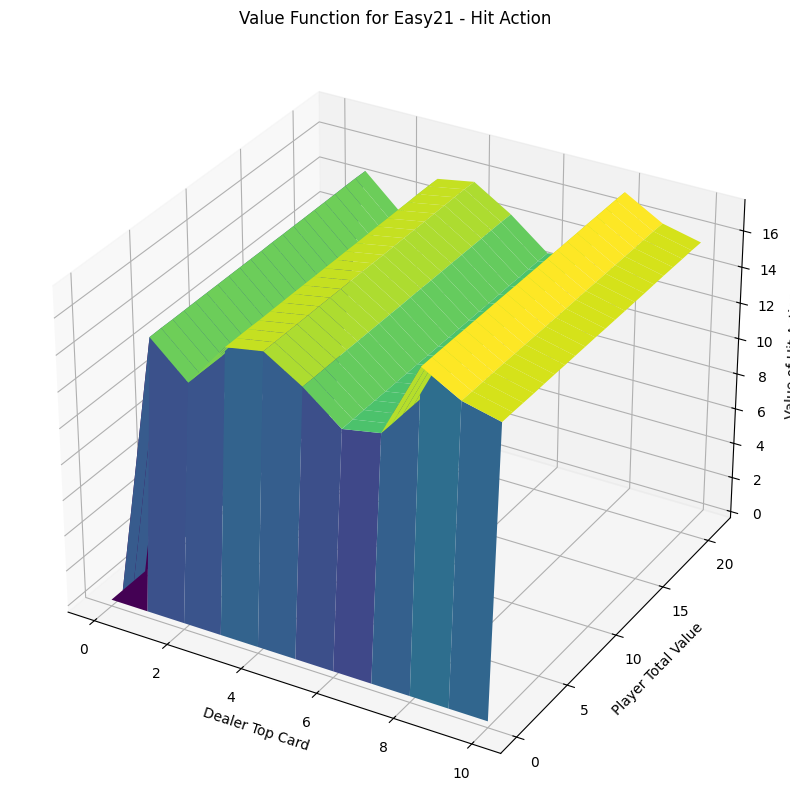

In [17]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(0, 11), np.arange(0, 22))
ax.plot_surface(X, Y, Z_0, cmap='viridis')
ax.set_xlabel('Dealer Top Card')
ax.set_ylabel('Player Total Value')
ax.set_zlabel('Value of Hit Action')
ax.set_title('Value Function for Easy21 - Hit Action')
plt.show()

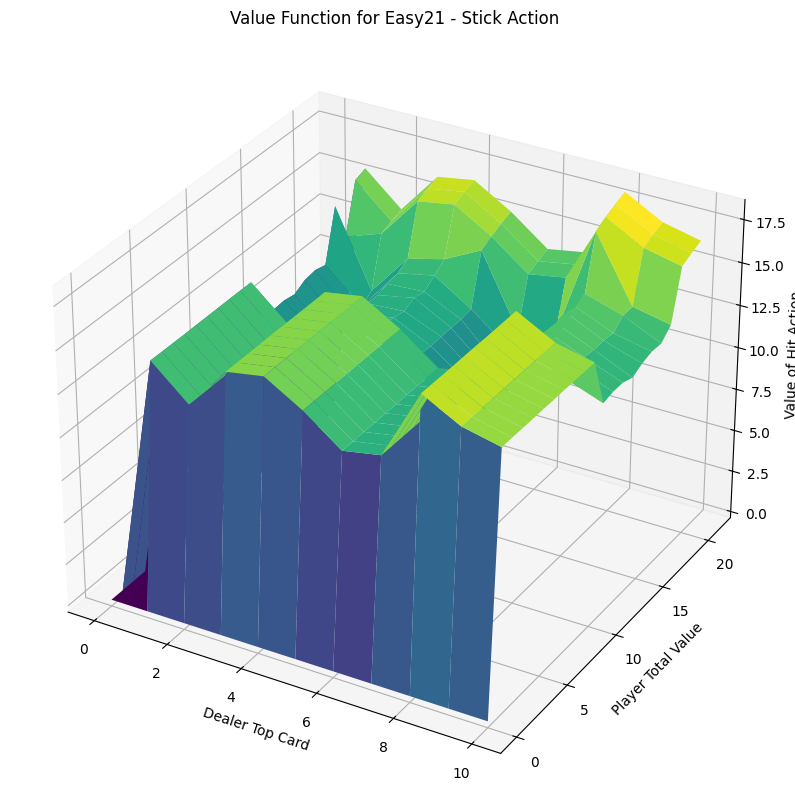

In [18]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_1, cmap='viridis')
ax.set_xlabel('Dealer Top Card')
ax.set_ylabel('Player Total Value')
ax.set_zlabel('Value of Hit Action')
ax.set_title('Value Function for Easy21 - Stick Action')
plt.show()

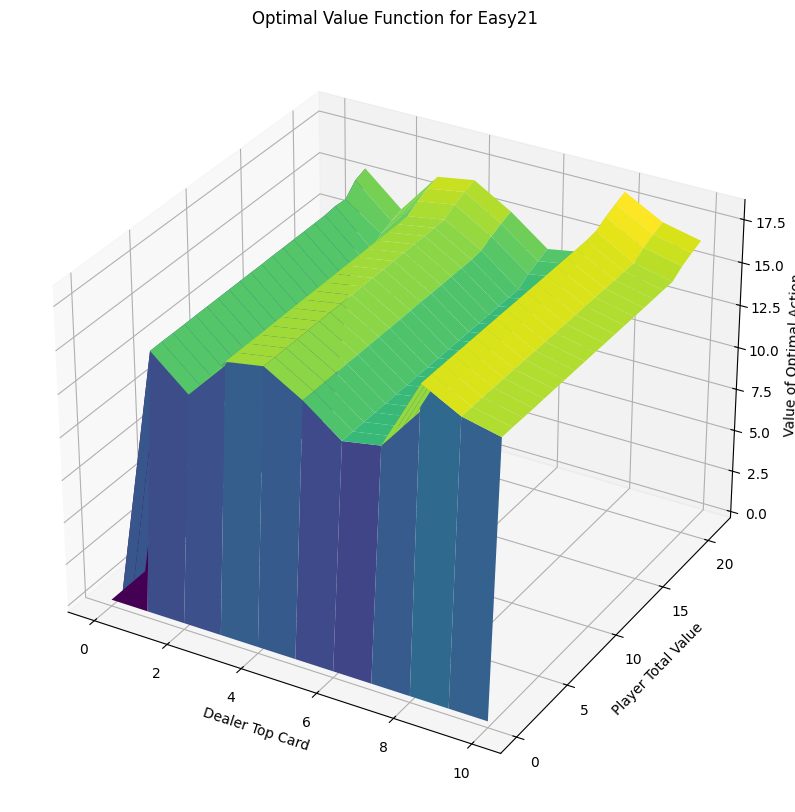

In [19]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('Dealer Top Card')
ax.set_ylabel('Player Total Value')
ax.set_zlabel('Value of Optimal Action')
ax.set_title('Optimal Value Function for Easy21')
plt.show()

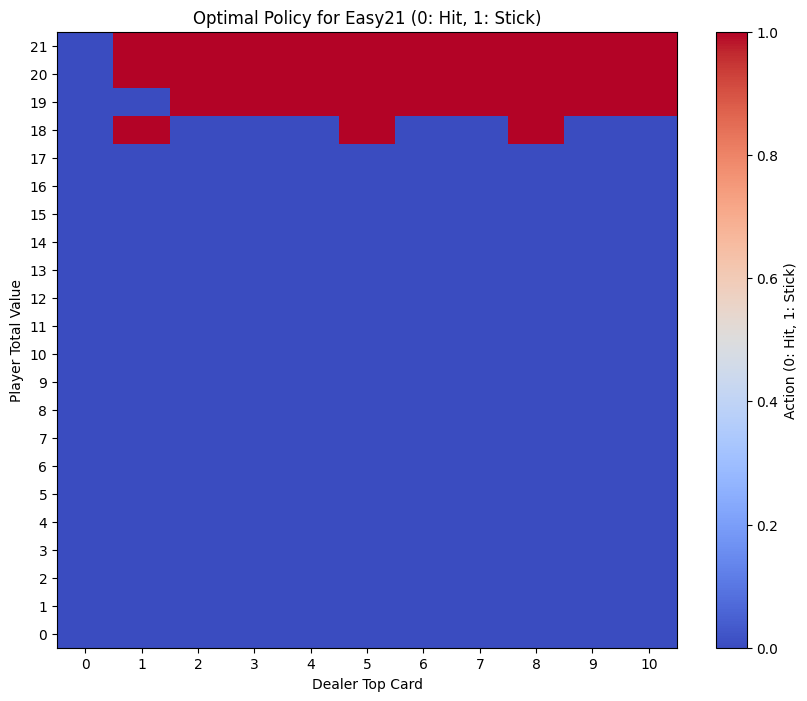

In [20]:
plt.figure(figsize=(10, 8))
plt.imshow(optimal_policy.T, origin='lower', aspect='auto', cmap='coolwarm')
plt.colorbar(label='Action (0: Hit, 1: Stick)')
plt.xlabel('Dealer Top Card')
plt.ylabel('Player Total Value')
plt.title('Optimal Policy for Easy21 (0: Hit, 1: Stick)')
plt.xticks(ticks=np.arange(optimal_policy.shape[0]), labels=np.arange(optimal_policy.shape[0]))
plt.yticks(ticks=np.arange(optimal_policy.shape[1]), labels=np.arange(optimal_policy.shape[1]))
plt.show()